In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import os
import numpy as np
from tqdm import tqdm

In [1]:
!kaggle datasets download -d sumithsingh/blood-cell-images-for-cancer-detection

Dataset URL: https://www.kaggle.com/datasets/sumithsingh/blood-cell-images-for-cancer-detection
License(s): Attribution 4.0 International (CC BY 4.0)




  0%|          | 0.00/122M [00:00<?, ?B/s]
  1%|          | 1.00M/122M [00:01<03:21, 628kB/s]
  2%|▏         | 2.00M/122M [00:01<01:38, 1.27MB/s]
  2%|▏         | 3.00M/122M [00:02<01:00, 2.05MB/s]
  4%|▍         | 5.00M/122M [00:02<00:31, 3.86MB/s]
  5%|▍         | 6.00M/122M [00:02<00:25, 4.71MB/s]
  7%|▋         | 8.00M/122M [00:02<00:18, 6.38MB/s]
  8%|▊         | 10.0M/122M [00:02<00:15, 7.50MB/s]
  9%|▉         | 11.0M/122M [00:02<00:14, 7.99MB/s]
 11%|█         | 13.0M/122M [00:02<00:12, 9.16MB/s]
 12%|█▏        | 15.0M/122M [00:03<00:11, 9.74MB/s]
 14%|█▍        | 17.0M/122M [00:03<00:10, 10.4MB/s]
 16%|█▌        | 19.0M/122M [00:03<00:10, 10.7MB/s]
 17%|█▋        | 21.0M/122M [00:03<00:09, 10.9MB/s]
 19%|█▉        | 23.0M/122M [00:03<00:09, 11.4MB/s]
 21%|██        | 25.0M/122M [00:04<00:09, 11.1MB/s]
 22%|██▏       | 27.0M/122M [00:04<00:09, 10.6MB/s]
 24%|██▍       | 29.0M/122M [00:04<00:09, 10.3MB/s]
 26%|██▌       | 31.0M/122M [00:04<00:10, 8.65MB/s]
 27%|██▋       | 33.0

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

class BloodCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                  self.image_paths.append(os.path.join(class_dir, filename))
                  self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
device='cuda'

In [13]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(64),       # Resize images for consistency
    transforms.ToTensor(),       # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])
# Create the dataset and dataloader
dataset = BloodCancerDataset(root_dir='blood_cancer_dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [14]:
for images, labels in dataloader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break #Stop after the first batch

Image batch shape: torch.Size([64, 3, 64, 64])
Label batch shape: torch.Size([64])


use DCGAN for generator and descriminator


In [18]:
# Define the Generator class with the same structure
class Generator(nn.Module):
    def __init__(self, latent_dim=100, channels=3):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            # Input is latent vector z
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # State size: (512, 4, 4)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State size: (256, 8, 8)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State size: (128, 16, 16)
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State size: (64, 32, 32)
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size: (channels, 64, 64)
        )

    def forward(self, z):
        return self.model(z)

# Define the Discriminator class with added dropout for regularization
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Input is (channels, 64, 64)
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),  # Added dropout for regularization
            # State size: (64, 32, 32)
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),  # Added dropout
            # State size: (128, 16, 16)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),  # Added dropout
            # State size: (256, 8, 8)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (512, 4, 4)
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)

# Create directory for saving results
os.makedirs("gan_results", exist_ok=True)

# Hyperparameters
latent_dim = 100
batch_size = 64
epochs = 200   #200/63
lr_g = 0.0002  # Generator learning rate
lr_d = 0.0001  # Discriminator learning rate (lower to prevent dominating)
beta1 = 0.5
beta2 = 0.999

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming dataset is defined elsewhere in your code
# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize models
generator = nn.DataParallel(Generator(latent_dim).to(device))
discriminator = nn.DataParallel(Discriminator().to(device))

# Initialize optimizers with different learning rates
optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, beta2))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))

# Evaluation function
def evaluate_model(generator, discriminator, dataloader, device):
    generator.eval()
    discriminator.eval()

    real_accs = []
    fake_accs = []

    with torch.no_grad():
        for real_imgs, _ in dataloader:
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            # Process real images
            real_preds = discriminator(real_imgs)
            real_acc = (real_preds > 0.5).float().mean().item()

            # Process fake images
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_imgs = generator(z)
            fake_preds = discriminator(fake_imgs)
            fake_acc = (fake_preds <= 0.5).float().mean().item()

            real_accs.append(real_acc)
            fake_accs.append(fake_acc)

    avg_real_acc = sum(real_accs) / len(real_accs)
    avg_fake_acc = sum(fake_accs) / len(fake_accs)
    avg_overall_acc = (avg_real_acc + avg_fake_acc) / 2

    print("\nEvaluation on Test Set:")
    print(f"Real Accuracy: {avg_real_acc:.4f}, Fake Accuracy: {avg_fake_acc:.4f}")
    print(f"Overall Accuracy: {avg_overall_acc:.4f}\n")

    generator.train()
    discriminator.train()

    return avg_overall_acc

# Loss function
adversarial_loss = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    g_losses = []
    d_losses = []
    real_accs = []
    fake_accs = []

    # Set models in training mode
    generator.train()
    discriminator.train()

    for i, (real_imgs, _) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
        # Move data to device
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # -----------------
        # Train Discriminator
        # -----------------
        optimizer_d.zero_grad()

        # Real images
        # Use label smoothing (0.9 instead of 1.0) for real images
        real_labels = torch.full((batch_size,), 0.9, device=device)
        real_preds = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_preds, real_labels)

        # Fake images
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = generator(z)
        fake_labels = torch.zeros(batch_size, device=device)

        # Add instance noise to improve training stability
        noise_factor = max(0, 0.1 * (1 - epoch/50))  # Linearly decrease noise over first 50 epochs
        if noise_factor > 0:
            fake_imgs_noisy = fake_imgs + noise_factor * torch.randn_like(fake_imgs)
            fake_preds = discriminator(fake_imgs_noisy.detach())
        else:
            fake_preds = discriminator(fake_imgs.detach())

        d_fake_loss = adversarial_loss(fake_preds, fake_labels)

        # Combined loss
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()

        # Only update discriminator every other batch (reduced update frequency)
        if i % 2 == 0:
            optimizer_d.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_g.zero_grad()

        # Generate new fake images for adversarial training
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = generator(z)

        # Try to fool the discriminator
        fake_preds = discriminator(fake_imgs)
        # Use soft labels for generator too
        soft_real_labels = torch.full((batch_size,), 0.9, device=device)
        g_loss = adversarial_loss(fake_preds, soft_real_labels)

        g_loss.backward()
        optimizer_g.step()

        # -----------------
        # Record metrics
        # -----------------
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        # Calculate accuracies for monitoring
        real_acc = (real_preds > 0.5).float().mean().item()
        fake_acc = (fake_preds <= 0.5).float().mean().item()
        real_accs.append(real_acc)
        fake_accs.append(fake_acc)

    # Print epoch statistics
    avg_g_loss = sum(g_losses) / len(g_losses)
    avg_d_loss = sum(d_losses) / len(d_losses)
    avg_real_acc = sum(real_accs) / len(real_accs)
    avg_fake_acc = sum(fake_accs) / len(fake_accs)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}")
    print(f"Real Accuracy: {avg_real_acc:.4f}, Fake Accuracy: {avg_fake_acc:.4f}")
    print(f"Overall Accuracy: {(avg_real_acc + avg_fake_acc) / 2:.4f}")


    # Evaluate on test set every 10 epochs
    if (epoch + 1) % 10 == 0:
        evaluate_model(generator, discriminator, test_dataloader, device)

    # Save generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        generator.eval()
        with torch.no_grad():
            sample_z = torch.randn(64, latent_dim, 1, 1, device=device)
            sample_imgs = generator(sample_z)
            save_image(sample_imgs, f"gan_results/epoch_{epoch+1}.png",
                      normalize=True, nrow=8)

    # Save models
    if (epoch + 1) % 50 == 0:
        torch.save(generator.state_dict(), f"gan_results/generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"gan_results/discriminator_epoch_{epoch+1}.pth")



Epoch 1/200: 100%|██████████| 63/63 [00:18<00:00,  3.41it/s]


Epoch 1/200
G Loss: 1.6674, D Loss: 1.2294
Real Accuracy: 0.6032, Fake Accuracy: 0.9474
Overall Accuracy: 0.7753


Epoch 2/200: 100%|██████████| 63/63 [00:17<00:00,  3.50it/s]


Epoch 2/200
G Loss: 0.9912, D Loss: 1.5766
Real Accuracy: 0.2237, Fake Accuracy: 0.8098
Overall Accuracy: 0.5167


Epoch 3/200: 100%|██████████| 63/63 [00:18<00:00,  3.49it/s]


Epoch 3/200
G Loss: 1.0771, D Loss: 1.4403
Real Accuracy: 0.3487, Fake Accuracy: 0.8735
Overall Accuracy: 0.6111


Epoch 4/200: 100%|██████████| 63/63 [00:18<00:00,  3.49it/s]


Epoch 4/200
G Loss: 1.0693, D Loss: 1.3736
Real Accuracy: 0.3931, Fake Accuracy: 0.8544
Overall Accuracy: 0.6238


Epoch 5/200: 100%|██████████| 63/63 [00:18<00:00,  3.47it/s]


Epoch 5/200
G Loss: 0.8495, D Loss: 1.4177
Real Accuracy: 0.3140, Fake Accuracy: 0.6942
Overall Accuracy: 0.5041


Epoch 6/200: 100%|██████████| 63/63 [00:18<00:00,  3.48it/s]


Epoch 6/200
G Loss: 0.7584, D Loss: 1.3509
Real Accuracy: 0.3951, Fake Accuracy: 0.5503
Overall Accuracy: 0.4727


Epoch 7/200: 100%|██████████| 63/63 [00:18<00:00,  3.46it/s]


Epoch 7/200
G Loss: 0.7651, D Loss: 1.3143
Real Accuracy: 0.4174, Fake Accuracy: 0.6012
Overall Accuracy: 0.5093


Epoch 8/200: 100%|██████████| 63/63 [00:17<00:00,  3.52it/s]


Epoch 8/200
G Loss: 0.7582, D Loss: 1.2830
Real Accuracy: 0.4306, Fake Accuracy: 0.5513
Overall Accuracy: 0.4909


Epoch 9/200: 100%|██████████| 63/63 [00:17<00:00,  3.51it/s]


Epoch 9/200
G Loss: 0.7067, D Loss: 1.1847
Real Accuracy: 0.5399, Fake Accuracy: 0.4492
Overall Accuracy: 0.4945


Epoch 10/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 10/200
G Loss: 0.6475, D Loss: 1.0949
Real Accuracy: 0.6314, Fake Accuracy: 0.3462
Overall Accuracy: 0.4888

Evaluation on Test Set:
Real Accuracy: 1.0000, Fake Accuracy: 0.0000
Overall Accuracy: 0.5000



Epoch 11/200: 100%|██████████| 63/63 [00:17<00:00,  3.51it/s]


Epoch 11/200
G Loss: 0.6739, D Loss: 0.9924
Real Accuracy: 0.6803, Fake Accuracy: 0.3710
Overall Accuracy: 0.5257


Epoch 12/200: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]


Epoch 12/200
G Loss: 0.5958, D Loss: 0.9070
Real Accuracy: 0.7651, Fake Accuracy: 0.2587
Overall Accuracy: 0.5119


Epoch 13/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 13/200
G Loss: 0.4922, D Loss: 0.7418
Real Accuracy: 0.8390, Fake Accuracy: 0.1409
Overall Accuracy: 0.4900


Epoch 14/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 14/200
G Loss: 0.5293, D Loss: 0.6268
Real Accuracy: 0.8872, Fake Accuracy: 0.1233
Overall Accuracy: 0.5052


Epoch 15/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 15/200
G Loss: 0.6220, D Loss: 0.6295
Real Accuracy: 0.8832, Fake Accuracy: 0.2101
Overall Accuracy: 0.5466


Epoch 16/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 16/200
G Loss: 0.4850, D Loss: 0.5438
Real Accuracy: 0.9239, Fake Accuracy: 0.0995
Overall Accuracy: 0.5117


Epoch 17/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 17/200
G Loss: 0.4372, D Loss: 0.4715
Real Accuracy: 0.9571, Fake Accuracy: 0.0707
Overall Accuracy: 0.5139


Epoch 18/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 18/200
G Loss: 0.3705, D Loss: 0.4074
Real Accuracy: 0.9876, Fake Accuracy: 0.0112
Overall Accuracy: 0.4994


Epoch 19/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 19/200
G Loss: 0.3757, D Loss: 0.4061
Real Accuracy: 0.9921, Fake Accuracy: 0.0161
Overall Accuracy: 0.5041


Epoch 20/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 20/200
G Loss: 0.3749, D Loss: 0.4055
Real Accuracy: 0.9874, Fake Accuracy: 0.0139
Overall Accuracy: 0.5006

Evaluation on Test Set:
Real Accuracy: 1.0000, Fake Accuracy: 0.0000
Overall Accuracy: 0.5000



Epoch 21/200: 100%|██████████| 63/63 [00:18<00:00,  3.48it/s]


Epoch 21/200
G Loss: 0.6320, D Loss: 0.5102
Real Accuracy: 0.9462, Fake Accuracy: 0.1052
Overall Accuracy: 0.5257


Epoch 22/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 22/200
G Loss: 0.5026, D Loss: 0.5609
Real Accuracy: 0.9306, Fake Accuracy: 0.1091
Overall Accuracy: 0.5198


Epoch 23/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 23/200
G Loss: 0.3811, D Loss: 0.4136
Real Accuracy: 0.9812, Fake Accuracy: 0.0241
Overall Accuracy: 0.5026


Epoch 24/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 24/200
G Loss: 0.3709, D Loss: 0.3847
Real Accuracy: 0.9965, Fake Accuracy: 0.0141
Overall Accuracy: 0.5053


Epoch 25/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 25/200
G Loss: 0.3953, D Loss: 0.4422
Real Accuracy: 0.9581, Fake Accuracy: 0.0335
Overall Accuracy: 0.4958


Epoch 26/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 26/200
G Loss: 0.4903, D Loss: 0.4752
Real Accuracy: 0.9556, Fake Accuracy: 0.1004
Overall Accuracy: 0.5280


Epoch 27/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 27/200
G Loss: 0.5122, D Loss: 0.4941
Real Accuracy: 0.9430, Fake Accuracy: 0.0975
Overall Accuracy: 0.5202


Epoch 28/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 28/200
G Loss: 0.6566, D Loss: 0.6216
Real Accuracy: 0.8589, Fake Accuracy: 0.1967
Overall Accuracy: 0.5278


Epoch 29/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 29/200
G Loss: 0.3814, D Loss: 0.4146
Real Accuracy: 0.9812, Fake Accuracy: 0.0216
Overall Accuracy: 0.5014


Epoch 30/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 30/200
G Loss: 0.5619, D Loss: 0.5720
Real Accuracy: 0.9065, Fake Accuracy: 0.1515
Overall Accuracy: 0.5290

Evaluation on Test Set:
Real Accuracy: 0.9916, Fake Accuracy: 0.0123
Overall Accuracy: 0.5020



Epoch 31/200: 100%|██████████| 63/63 [00:18<00:00,  3.49it/s]


Epoch 31/200
G Loss: 0.7006, D Loss: 0.6401
Real Accuracy: 0.8847, Fake Accuracy: 0.2369
Overall Accuracy: 0.5608


Epoch 32/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 32/200
G Loss: 0.5030, D Loss: 0.5441
Real Accuracy: 0.9308, Fake Accuracy: 0.1039
Overall Accuracy: 0.5174


Epoch 33/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 33/200
G Loss: 0.4368, D Loss: 0.4708
Real Accuracy: 0.9526, Fake Accuracy: 0.0791
Overall Accuracy: 0.5159


Epoch 34/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 34/200
G Loss: 0.8318, D Loss: 0.7079
Real Accuracy: 0.8495, Fake Accuracy: 0.2741
Overall Accuracy: 0.5618


Epoch 35/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 35/200
G Loss: 0.7509, D Loss: 0.6679
Real Accuracy: 0.8385, Fake Accuracy: 0.2599
Overall Accuracy: 0.5492


Epoch 36/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 36/200
G Loss: 0.7967, D Loss: 0.6594
Real Accuracy: 0.8569, Fake Accuracy: 0.2877
Overall Accuracy: 0.5723


Epoch 37/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 37/200
G Loss: 0.7339, D Loss: 0.6742
Real Accuracy: 0.8430, Fake Accuracy: 0.2902
Overall Accuracy: 0.5666


Epoch 38/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 38/200
G Loss: 0.9403, D Loss: 0.8385
Real Accuracy: 0.7750, Fake Accuracy: 0.3849
Overall Accuracy: 0.5800


Epoch 39/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 39/200
G Loss: 0.9356, D Loss: 0.8915
Real Accuracy: 0.7669, Fake Accuracy: 0.4325
Overall Accuracy: 0.5997


Epoch 40/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 40/200
G Loss: 1.0303, D Loss: 1.0613
Real Accuracy: 0.6644, Fake Accuracy: 0.4812
Overall Accuracy: 0.5728

Evaluation on Test Set:
Real Accuracy: 0.5510, Fake Accuracy: 0.5680
Overall Accuracy: 0.5595



Epoch 41/200: 100%|██████████| 63/63 [00:18<00:00,  3.50it/s]


Epoch 41/200
G Loss: 0.9732, D Loss: 0.9895
Real Accuracy: 0.6825, Fake Accuracy: 0.5060
Overall Accuracy: 0.5942


Epoch 42/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 42/200
G Loss: 1.0816, D Loss: 1.1356
Real Accuracy: 0.6290, Fake Accuracy: 0.5918
Overall Accuracy: 0.6104


Epoch 43/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 43/200
G Loss: 1.0592, D Loss: 1.1479
Real Accuracy: 0.5866, Fake Accuracy: 0.6042
Overall Accuracy: 0.5954


Epoch 44/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 44/200
G Loss: 1.1208, D Loss: 1.1913
Real Accuracy: 0.5481, Fake Accuracy: 0.7227
Overall Accuracy: 0.6354


Epoch 45/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 45/200
G Loss: 1.1082, D Loss: 1.2543
Real Accuracy: 0.5032, Fake Accuracy: 0.7587
Overall Accuracy: 0.6310


Epoch 46/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 46/200
G Loss: 1.0885, D Loss: 1.3079
Real Accuracy: 0.4526, Fake Accuracy: 0.7937
Overall Accuracy: 0.6231


Epoch 47/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 47/200
G Loss: 1.1932, D Loss: 1.3089
Real Accuracy: 0.4216, Fake Accuracy: 0.8800
Overall Accuracy: 0.6508


Epoch 48/200: 100%|██████████| 63/63 [00:17<00:00,  3.52it/s]


Epoch 48/200
G Loss: 1.2030, D Loss: 1.3699
Real Accuracy: 0.4147, Fake Accuracy: 0.8777
Overall Accuracy: 0.6462


Epoch 49/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 49/200
G Loss: 1.0667, D Loss: 1.3372
Real Accuracy: 0.4204, Fake Accuracy: 0.8522
Overall Accuracy: 0.6363


Epoch 50/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 50/200
G Loss: 1.0642, D Loss: 1.4114
Real Accuracy: 0.3519, Fake Accuracy: 0.8981
Overall Accuracy: 0.6250

Evaluation on Test Set:
Real Accuracy: 0.1766, Fake Accuracy: 0.9080
Overall Accuracy: 0.5423



Epoch 51/200: 100%|██████████| 63/63 [00:17<00:00,  3.51it/s]


Epoch 51/200
G Loss: 0.9858, D Loss: 1.3497
Real Accuracy: 0.3834, Fake Accuracy: 0.8661
Overall Accuracy: 0.6248


Epoch 52/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 52/200
G Loss: 1.0462, D Loss: 1.3307
Real Accuracy: 0.3961, Fake Accuracy: 0.8760
Overall Accuracy: 0.6360


Epoch 53/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 53/200
G Loss: 0.9501, D Loss: 1.3328
Real Accuracy: 0.3968, Fake Accuracy: 0.8524
Overall Accuracy: 0.6246


Epoch 54/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 54/200
G Loss: 1.0029, D Loss: 1.3553
Real Accuracy: 0.3713, Fake Accuracy: 0.9107
Overall Accuracy: 0.6410


Epoch 55/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 55/200
G Loss: 0.9651, D Loss: 1.3243
Real Accuracy: 0.3822, Fake Accuracy: 0.8827
Overall Accuracy: 0.6324


Epoch 56/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 56/200
G Loss: 0.9666, D Loss: 1.3467
Real Accuracy: 0.3626, Fake Accuracy: 0.8958
Overall Accuracy: 0.6292


Epoch 57/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 57/200
G Loss: 0.9609, D Loss: 1.3235
Real Accuracy: 0.3795, Fake Accuracy: 0.8785
Overall Accuracy: 0.6290


Epoch 58/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 58/200
G Loss: 0.9752, D Loss: 1.3210
Real Accuracy: 0.3752, Fake Accuracy: 0.9033
Overall Accuracy: 0.6393


Epoch 59/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 59/200
G Loss: 1.0054, D Loss: 1.3564
Real Accuracy: 0.3596, Fake Accuracy: 0.9015
Overall Accuracy: 0.6306


Epoch 60/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 60/200
G Loss: 0.9714, D Loss: 1.3186
Real Accuracy: 0.3911, Fake Accuracy: 0.9137
Overall Accuracy: 0.6524

Evaluation on Test Set:
Real Accuracy: 0.3283, Fake Accuracy: 0.9541
Overall Accuracy: 0.6412



Epoch 61/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 61/200
G Loss: 0.9695, D Loss: 1.3068
Real Accuracy: 0.3934, Fake Accuracy: 0.8998
Overall Accuracy: 0.6466


Epoch 62/200: 100%|██████████| 63/63 [00:17<00:00,  3.63it/s]


Epoch 62/200
G Loss: 0.9507, D Loss: 1.3143
Real Accuracy: 0.4000, Fake Accuracy: 0.8904
Overall Accuracy: 0.6452


Epoch 63/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 63/200
G Loss: 0.9449, D Loss: 1.3179
Real Accuracy: 0.3713, Fake Accuracy: 0.8946
Overall Accuracy: 0.6329


Epoch 64/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 64/200
G Loss: 0.9639, D Loss: 1.2990
Real Accuracy: 0.4015, Fake Accuracy: 0.8961
Overall Accuracy: 0.6488


Epoch 65/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 65/200
G Loss: 0.9719, D Loss: 1.3212
Real Accuracy: 0.3748, Fake Accuracy: 0.8956
Overall Accuracy: 0.6352


Epoch 66/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 66/200
G Loss: 0.9913, D Loss: 1.2921
Real Accuracy: 0.4216, Fake Accuracy: 0.8847
Overall Accuracy: 0.6531


Epoch 67/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 67/200
G Loss: 0.9749, D Loss: 1.3062
Real Accuracy: 0.4055, Fake Accuracy: 0.9090
Overall Accuracy: 0.6572


Epoch 68/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 68/200
G Loss: 0.9578, D Loss: 1.3293
Real Accuracy: 0.3688, Fake Accuracy: 0.8869
Overall Accuracy: 0.6279


Epoch 69/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 69/200
G Loss: 0.9935, D Loss: 1.2973
Real Accuracy: 0.3978, Fake Accuracy: 0.8916
Overall Accuracy: 0.6447


Epoch 70/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 70/200
G Loss: 0.9633, D Loss: 1.2931
Real Accuracy: 0.4030, Fake Accuracy: 0.8914
Overall Accuracy: 0.6472

Evaluation on Test Set:
Real Accuracy: 0.2502, Fake Accuracy: 0.9146
Overall Accuracy: 0.5824



Epoch 71/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 71/200
G Loss: 0.9570, D Loss: 1.3119
Real Accuracy: 0.3854, Fake Accuracy: 0.8819
Overall Accuracy: 0.6337


Epoch 72/200: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]


Epoch 72/200
G Loss: 0.9855, D Loss: 1.3097
Real Accuracy: 0.4062, Fake Accuracy: 0.8941
Overall Accuracy: 0.6502


Epoch 73/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 73/200
G Loss: 0.9912, D Loss: 1.2978
Real Accuracy: 0.4293, Fake Accuracy: 0.8916
Overall Accuracy: 0.6605


Epoch 74/200: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]


Epoch 74/200
G Loss: 0.9967, D Loss: 1.3190
Real Accuracy: 0.3822, Fake Accuracy: 0.9043
Overall Accuracy: 0.6432


Epoch 75/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 75/200
G Loss: 0.9549, D Loss: 1.3088
Real Accuracy: 0.4080, Fake Accuracy: 0.8844
Overall Accuracy: 0.6462


Epoch 76/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 76/200
G Loss: 1.0127, D Loss: 1.2831
Real Accuracy: 0.4449, Fake Accuracy: 0.8991
Overall Accuracy: 0.6720


Epoch 77/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 77/200
G Loss: 0.9800, D Loss: 1.2781
Real Accuracy: 0.4343, Fake Accuracy: 0.9013
Overall Accuracy: 0.6678


Epoch 78/200: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]


Epoch 78/200
G Loss: 0.9882, D Loss: 1.2662
Real Accuracy: 0.4616, Fake Accuracy: 0.8934
Overall Accuracy: 0.6775


Epoch 79/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 79/200
G Loss: 1.0449, D Loss: 1.2506
Real Accuracy: 0.4402, Fake Accuracy: 0.9338
Overall Accuracy: 0.6870


Epoch 80/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 80/200
G Loss: 1.0176, D Loss: 1.2827
Real Accuracy: 0.4368, Fake Accuracy: 0.9010
Overall Accuracy: 0.6689

Evaluation on Test Set:
Real Accuracy: 0.4498, Fake Accuracy: 0.6076
Overall Accuracy: 0.5287



Epoch 81/200: 100%|██████████| 63/63 [00:17<00:00,  3.52it/s]


Epoch 81/200
G Loss: 1.0680, D Loss: 1.2359
Real Accuracy: 0.4809, Fake Accuracy: 0.9231
Overall Accuracy: 0.7020


Epoch 82/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 82/200
G Loss: 1.0421, D Loss: 1.2280
Real Accuracy: 0.5027, Fake Accuracy: 0.8862
Overall Accuracy: 0.6944


Epoch 83/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 83/200
G Loss: 1.1065, D Loss: 1.2363
Real Accuracy: 0.4866, Fake Accuracy: 0.9167
Overall Accuracy: 0.7016


Epoch 84/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 84/200
G Loss: 1.0710, D Loss: 1.2479
Real Accuracy: 0.4623, Fake Accuracy: 0.9120
Overall Accuracy: 0.6871


Epoch 85/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 85/200
G Loss: 1.0908, D Loss: 1.2366
Real Accuracy: 0.5213, Fake Accuracy: 0.9182
Overall Accuracy: 0.7197


Epoch 86/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 86/200
G Loss: 1.1013, D Loss: 1.2244
Real Accuracy: 0.5193, Fake Accuracy: 0.9092
Overall Accuracy: 0.7143


Epoch 87/200: 100%|██████████| 63/63 [00:17<00:00,  3.52it/s]


Epoch 87/200
G Loss: 1.1557, D Loss: 1.1915
Real Accuracy: 0.5451, Fake Accuracy: 0.9276
Overall Accuracy: 0.7364


Epoch 88/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 88/200
G Loss: 1.1968, D Loss: 1.2103
Real Accuracy: 0.5464, Fake Accuracy: 0.9077
Overall Accuracy: 0.7271


Epoch 89/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 89/200
G Loss: 1.1232, D Loss: 1.1933
Real Accuracy: 0.5198, Fake Accuracy: 0.9149
Overall Accuracy: 0.7174


Epoch 90/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 90/200
G Loss: 1.2237, D Loss: 1.1878
Real Accuracy: 0.5186, Fake Accuracy: 0.9236
Overall Accuracy: 0.7211

Evaluation on Test Set:
Real Accuracy: 0.4215, Fake Accuracy: 0.9932
Overall Accuracy: 0.7073



Epoch 91/200: 100%|██████████| 63/63 [00:18<00:00,  3.48it/s]


Epoch 91/200
G Loss: 1.2403, D Loss: 1.1440
Real Accuracy: 0.5856, Fake Accuracy: 0.9283
Overall Accuracy: 0.7569


Epoch 92/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 92/200
G Loss: 1.2375, D Loss: 1.1500
Real Accuracy: 0.5486, Fake Accuracy: 0.9437
Overall Accuracy: 0.7462


Epoch 93/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 93/200
G Loss: 1.2853, D Loss: 1.1462
Real Accuracy: 0.5516, Fake Accuracy: 0.9323
Overall Accuracy: 0.7419


Epoch 94/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 94/200
G Loss: 1.1912, D Loss: 1.1115
Real Accuracy: 0.5942, Fake Accuracy: 0.9189
Overall Accuracy: 0.7566


Epoch 95/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 95/200
G Loss: 1.3728, D Loss: 1.1109
Real Accuracy: 0.5843, Fake Accuracy: 0.9484
Overall Accuracy: 0.7664


Epoch 96/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 96/200
G Loss: 1.4254, D Loss: 1.1258
Real Accuracy: 0.5657, Fake Accuracy: 0.9377
Overall Accuracy: 0.7517


Epoch 97/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 97/200
G Loss: 1.3335, D Loss: 1.0961
Real Accuracy: 0.6183, Fake Accuracy: 0.9278
Overall Accuracy: 0.7731


Epoch 98/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 98/200
G Loss: 1.3494, D Loss: 1.1040
Real Accuracy: 0.6084, Fake Accuracy: 0.9139
Overall Accuracy: 0.7612


Epoch 99/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 99/200
G Loss: 1.4206, D Loss: 1.0631
Real Accuracy: 0.6178, Fake Accuracy: 0.9526
Overall Accuracy: 0.7852


Epoch 100/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 100/200
G Loss: 1.4322, D Loss: 1.0993
Real Accuracy: 0.6007, Fake Accuracy: 0.9229
Overall Accuracy: 0.7618

Evaluation on Test Set:
Real Accuracy: 0.2693, Fake Accuracy: 0.9559
Overall Accuracy: 0.6126



Epoch 101/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 101/200
G Loss: 1.5184, D Loss: 1.0793
Real Accuracy: 0.6394, Fake Accuracy: 0.9536
Overall Accuracy: 0.7965


Epoch 102/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 102/200
G Loss: 1.5682, D Loss: 1.0463
Real Accuracy: 0.6205, Fake Accuracy: 0.9581
Overall Accuracy: 0.7893


Epoch 103/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 103/200
G Loss: 1.4855, D Loss: 1.0306
Real Accuracy: 0.6436, Fake Accuracy: 0.9343
Overall Accuracy: 0.7889


Epoch 104/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 104/200
G Loss: 1.4316, D Loss: 1.0079
Real Accuracy: 0.6927, Fake Accuracy: 0.9494
Overall Accuracy: 0.8211


Epoch 105/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 105/200
G Loss: 1.5080, D Loss: 1.0453
Real Accuracy: 0.6466, Fake Accuracy: 0.9273
Overall Accuracy: 0.7870


Epoch 106/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 106/200
G Loss: 1.4683, D Loss: 0.9812
Real Accuracy: 0.7235, Fake Accuracy: 0.9363
Overall Accuracy: 0.8299


Epoch 107/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 107/200
G Loss: 1.5615, D Loss: 1.0104
Real Accuracy: 0.6595, Fake Accuracy: 0.9375
Overall Accuracy: 0.7985


Epoch 108/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 108/200
G Loss: 1.5749, D Loss: 1.0138
Real Accuracy: 0.6716, Fake Accuracy: 0.9516
Overall Accuracy: 0.8116


Epoch 109/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 109/200
G Loss: 1.6317, D Loss: 0.9691
Real Accuracy: 0.7096, Fake Accuracy: 0.9444
Overall Accuracy: 0.8270


Epoch 110/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 110/200
G Loss: 1.5884, D Loss: 1.0190
Real Accuracy: 0.6726, Fake Accuracy: 0.9278
Overall Accuracy: 0.8002

Evaluation on Test Set:
Real Accuracy: 0.3605, Fake Accuracy: 0.9838
Overall Accuracy: 0.6722



Epoch 111/200: 100%|██████████| 63/63 [00:17<00:00,  3.51it/s]


Epoch 111/200
G Loss: 1.5629, D Loss: 0.9694
Real Accuracy: 0.6999, Fake Accuracy: 0.9430
Overall Accuracy: 0.8214


Epoch 112/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 112/200
G Loss: 1.6707, D Loss: 0.9212
Real Accuracy: 0.7192, Fake Accuracy: 0.9541
Overall Accuracy: 0.8367


Epoch 113/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 113/200
G Loss: 1.8544, D Loss: 0.9144
Real Accuracy: 0.7264, Fake Accuracy: 0.9581
Overall Accuracy: 0.8423


Epoch 114/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 114/200
G Loss: 1.7215, D Loss: 1.0004
Real Accuracy: 0.6815, Fake Accuracy: 0.9380
Overall Accuracy: 0.8098


Epoch 115/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 115/200
G Loss: 1.5666, D Loss: 0.9632
Real Accuracy: 0.7063, Fake Accuracy: 0.9325
Overall Accuracy: 0.8194


Epoch 116/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 116/200
G Loss: 1.6202, D Loss: 0.9443
Real Accuracy: 0.7059, Fake Accuracy: 0.9623
Overall Accuracy: 0.8341


Epoch 117/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 117/200
G Loss: 1.6095, D Loss: 0.9594
Real Accuracy: 0.7063, Fake Accuracy: 0.9283
Overall Accuracy: 0.8173


Epoch 118/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 118/200
G Loss: 1.5907, D Loss: 0.9652
Real Accuracy: 0.7220, Fake Accuracy: 0.9070
Overall Accuracy: 0.8145


Epoch 119/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 119/200
G Loss: 1.5721, D Loss: 0.9205
Real Accuracy: 0.7245, Fake Accuracy: 0.9566
Overall Accuracy: 0.8405


Epoch 120/200: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]


Epoch 120/200
G Loss: 1.6381, D Loss: 0.9396
Real Accuracy: 0.7160, Fake Accuracy: 0.9397
Overall Accuracy: 0.8279

Evaluation on Test Set:
Real Accuracy: 0.1072, Fake Accuracy: 1.0000
Overall Accuracy: 0.5536



Epoch 121/200: 100%|██████████| 63/63 [00:17<00:00,  3.51it/s]


Epoch 121/200
G Loss: 1.5243, D Loss: 0.9915
Real Accuracy: 0.6954, Fake Accuracy: 0.9060
Overall Accuracy: 0.8007


Epoch 122/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 122/200
G Loss: 1.5405, D Loss: 0.9863
Real Accuracy: 0.7046, Fake Accuracy: 0.8943
Overall Accuracy: 0.7995


Epoch 123/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 123/200
G Loss: 1.5651, D Loss: 1.0542
Real Accuracy: 0.6964, Fake Accuracy: 0.8934
Overall Accuracy: 0.7949


Epoch 124/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 124/200
G Loss: 1.5088, D Loss: 1.0156
Real Accuracy: 0.6811, Fake Accuracy: 0.9511
Overall Accuracy: 0.8161


Epoch 125/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 125/200
G Loss: 1.4433, D Loss: 0.9723
Real Accuracy: 0.7073, Fake Accuracy: 0.9191
Overall Accuracy: 0.8132


Epoch 126/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 126/200
G Loss: 1.4159, D Loss: 1.0357
Real Accuracy: 0.6659, Fake Accuracy: 0.8839
Overall Accuracy: 0.7749


Epoch 127/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 127/200
G Loss: 1.4085, D Loss: 1.0804
Real Accuracy: 0.6305, Fake Accuracy: 0.8879
Overall Accuracy: 0.7592


Epoch 128/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 128/200
G Loss: 1.4265, D Loss: 1.0611
Real Accuracy: 0.6620, Fake Accuracy: 0.9105
Overall Accuracy: 0.7862


Epoch 129/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 129/200
G Loss: 1.3590, D Loss: 1.0489
Real Accuracy: 0.6714, Fake Accuracy: 0.8797
Overall Accuracy: 0.7755


Epoch 130/200: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]


Epoch 130/200
G Loss: 1.3660, D Loss: 1.0972
Real Accuracy: 0.6555, Fake Accuracy: 0.8480
Overall Accuracy: 0.7517

Evaluation on Test Set:
Real Accuracy: 0.0709, Fake Accuracy: 1.0000
Overall Accuracy: 0.5354



Epoch 131/200: 100%|██████████| 63/63 [00:17<00:00,  3.52it/s]


Epoch 131/200
G Loss: 1.2933, D Loss: 1.1223
Real Accuracy: 0.6133, Fake Accuracy: 0.8857
Overall Accuracy: 0.7495


Epoch 132/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 132/200
G Loss: 1.3003, D Loss: 1.1329
Real Accuracy: 0.5938, Fake Accuracy: 0.8450
Overall Accuracy: 0.7194


Epoch 133/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 133/200
G Loss: 1.2778, D Loss: 1.0518
Real Accuracy: 0.6682, Fake Accuracy: 0.9015
Overall Accuracy: 0.7848


Epoch 134/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 134/200
G Loss: 1.2160, D Loss: 1.1171
Real Accuracy: 0.6297, Fake Accuracy: 0.8326
Overall Accuracy: 0.7312


Epoch 135/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 135/200
G Loss: 1.2523, D Loss: 1.1184
Real Accuracy: 0.6126, Fake Accuracy: 0.8497
Overall Accuracy: 0.7312


Epoch 136/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 136/200
G Loss: 1.2412, D Loss: 1.1600
Real Accuracy: 0.5992, Fake Accuracy: 0.8199
Overall Accuracy: 0.7096


Epoch 137/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 137/200
G Loss: 1.1964, D Loss: 1.1179
Real Accuracy: 0.6300, Fake Accuracy: 0.8514
Overall Accuracy: 0.7407


Epoch 138/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 138/200
G Loss: 1.2245, D Loss: 1.1119
Real Accuracy: 0.6059, Fake Accuracy: 0.8862
Overall Accuracy: 0.7460


Epoch 139/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 139/200
G Loss: 1.2515, D Loss: 1.1342
Real Accuracy: 0.6029, Fake Accuracy: 0.8745
Overall Accuracy: 0.7387


Epoch 140/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 140/200
G Loss: 1.2370, D Loss: 1.0943
Real Accuracy: 0.6481, Fake Accuracy: 0.8879
Overall Accuracy: 0.7680

Evaluation on Test Set:
Real Accuracy: 0.3959, Fake Accuracy: 0.9352
Overall Accuracy: 0.6655



Epoch 141/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 141/200
G Loss: 1.2735, D Loss: 1.1677
Real Accuracy: 0.5508, Fake Accuracy: 0.8338
Overall Accuracy: 0.6923


Epoch 142/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 142/200
G Loss: 1.2335, D Loss: 1.1403
Real Accuracy: 0.5972, Fake Accuracy: 0.8438
Overall Accuracy: 0.7205


Epoch 143/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 143/200
G Loss: 1.2425, D Loss: 1.1689
Real Accuracy: 0.5801, Fake Accuracy: 0.8686
Overall Accuracy: 0.7243


Epoch 144/200: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]


Epoch 144/200
G Loss: 1.1504, D Loss: 1.1251
Real Accuracy: 0.5957, Fake Accuracy: 0.8492
Overall Accuracy: 0.7225


Epoch 145/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 145/200
G Loss: 1.1799, D Loss: 1.1788
Real Accuracy: 0.6044, Fake Accuracy: 0.8418
Overall Accuracy: 0.7231


Epoch 146/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 146/200
G Loss: 1.1468, D Loss: 1.1440
Real Accuracy: 0.5786, Fake Accuracy: 0.8549
Overall Accuracy: 0.7168


Epoch 147/200: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]


Epoch 147/200
G Loss: 1.1676, D Loss: 1.2052
Real Accuracy: 0.5940, Fake Accuracy: 0.8217
Overall Accuracy: 0.7078


Epoch 148/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 148/200
G Loss: 1.1447, D Loss: 1.1594
Real Accuracy: 0.5848, Fake Accuracy: 0.8438
Overall Accuracy: 0.7143


Epoch 149/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 149/200
G Loss: 1.1461, D Loss: 1.1841
Real Accuracy: 0.5632, Fake Accuracy: 0.8403
Overall Accuracy: 0.7018


Epoch 150/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 150/200
G Loss: 1.1306, D Loss: 1.2210
Real Accuracy: 0.5439, Fake Accuracy: 0.8276
Overall Accuracy: 0.6858

Evaluation on Test Set:
Real Accuracy: 0.1732, Fake Accuracy: 0.9484
Overall Accuracy: 0.5608



Epoch 151/200: 100%|██████████| 63/63 [00:17<00:00,  3.50it/s]


Epoch 151/200
G Loss: 1.1230, D Loss: 1.1618
Real Accuracy: 0.5923, Fake Accuracy: 0.8470
Overall Accuracy: 0.7196


Epoch 152/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 152/200
G Loss: 1.1675, D Loss: 1.1870
Real Accuracy: 0.5680, Fake Accuracy: 0.8249
Overall Accuracy: 0.6964


Epoch 153/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 153/200
G Loss: 1.1185, D Loss: 1.1877
Real Accuracy: 0.5754, Fake Accuracy: 0.8180
Overall Accuracy: 0.6967


Epoch 154/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 154/200
G Loss: 1.1083, D Loss: 1.2269
Real Accuracy: 0.5687, Fake Accuracy: 0.7669
Overall Accuracy: 0.6678


Epoch 155/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 155/200
G Loss: 1.0738, D Loss: 1.1716
Real Accuracy: 0.5895, Fake Accuracy: 0.8487
Overall Accuracy: 0.7191


Epoch 156/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 156/200
G Loss: 1.0496, D Loss: 1.2016
Real Accuracy: 0.5985, Fake Accuracy: 0.7954
Overall Accuracy: 0.6969


Epoch 157/200: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]


Epoch 157/200
G Loss: 1.0664, D Loss: 1.2207
Real Accuracy: 0.5541, Fake Accuracy: 0.8088
Overall Accuracy: 0.6814


Epoch 158/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 158/200
G Loss: 1.1169, D Loss: 1.1844
Real Accuracy: 0.5838, Fake Accuracy: 0.8175
Overall Accuracy: 0.7006


Epoch 159/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 159/200
G Loss: 1.0563, D Loss: 1.2089
Real Accuracy: 0.5657, Fake Accuracy: 0.8118
Overall Accuracy: 0.6887


Epoch 160/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 160/200
G Loss: 1.0865, D Loss: 1.1775
Real Accuracy: 0.5464, Fake Accuracy: 0.8562
Overall Accuracy: 0.7013

Evaluation on Test Set:
Real Accuracy: 0.1529, Fake Accuracy: 0.9643
Overall Accuracy: 0.5586



Epoch 161/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 161/200
G Loss: 1.1307, D Loss: 1.2398
Real Accuracy: 0.5268, Fake Accuracy: 0.8363
Overall Accuracy: 0.6815


Epoch 162/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 162/200
G Loss: 1.0500, D Loss: 1.1777
Real Accuracy: 0.5908, Fake Accuracy: 0.8177
Overall Accuracy: 0.7042


Epoch 163/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 163/200
G Loss: 1.0718, D Loss: 1.2195
Real Accuracy: 0.5419, Fake Accuracy: 0.8497
Overall Accuracy: 0.6958


Epoch 164/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 164/200
G Loss: 1.0948, D Loss: 1.2255
Real Accuracy: 0.5474, Fake Accuracy: 0.8080
Overall Accuracy: 0.6777


Epoch 165/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 165/200
G Loss: 1.0595, D Loss: 1.2082
Real Accuracy: 0.5742, Fake Accuracy: 0.8232
Overall Accuracy: 0.6987


Epoch 166/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 166/200
G Loss: 1.0893, D Loss: 1.1828
Real Accuracy: 0.5627, Fake Accuracy: 0.8576
Overall Accuracy: 0.7102


Epoch 167/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 167/200
G Loss: 1.1136, D Loss: 1.2058
Real Accuracy: 0.5786, Fake Accuracy: 0.8485
Overall Accuracy: 0.7135


Epoch 168/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 168/200
G Loss: 1.0708, D Loss: 1.1947
Real Accuracy: 0.5709, Fake Accuracy: 0.8244
Overall Accuracy: 0.6977


Epoch 169/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 169/200
G Loss: 1.0909, D Loss: 1.2179
Real Accuracy: 0.5526, Fake Accuracy: 0.8160
Overall Accuracy: 0.6843


Epoch 170/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 170/200
G Loss: 1.0652, D Loss: 1.1976
Real Accuracy: 0.5578, Fake Accuracy: 0.8671
Overall Accuracy: 0.7124

Evaluation on Test Set:
Real Accuracy: 0.2096, Fake Accuracy: 0.9420
Overall Accuracy: 0.5758



Epoch 171/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 171/200
G Loss: 1.0568, D Loss: 1.2291
Real Accuracy: 0.5511, Fake Accuracy: 0.8023
Overall Accuracy: 0.6767


Epoch 172/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 172/200
G Loss: 1.0695, D Loss: 1.2513
Real Accuracy: 0.4995, Fake Accuracy: 0.8435
Overall Accuracy: 0.6715


Epoch 173/200: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]


Epoch 173/200
G Loss: 1.0297, D Loss: 1.2202
Real Accuracy: 0.5801, Fake Accuracy: 0.8070
Overall Accuracy: 0.6936


Epoch 174/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 174/200
G Loss: 1.0556, D Loss: 1.2044
Real Accuracy: 0.5796, Fake Accuracy: 0.8346
Overall Accuracy: 0.7071


Epoch 175/200: 100%|██████████| 63/63 [00:18<00:00,  3.49it/s]


Epoch 175/200
G Loss: 1.0788, D Loss: 1.2324
Real Accuracy: 0.5042, Fake Accuracy: 0.8589
Overall Accuracy: 0.6815


Epoch 176/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 176/200
G Loss: 1.0364, D Loss: 1.2233
Real Accuracy: 0.5469, Fake Accuracy: 0.7882
Overall Accuracy: 0.6675


Epoch 177/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 177/200
G Loss: 1.0859, D Loss: 1.2313
Real Accuracy: 0.5471, Fake Accuracy: 0.8480
Overall Accuracy: 0.6975


Epoch 178/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 178/200
G Loss: 1.0736, D Loss: 1.2315
Real Accuracy: 0.5521, Fake Accuracy: 0.7847
Overall Accuracy: 0.6684


Epoch 179/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 179/200
G Loss: 1.0566, D Loss: 1.2588
Real Accuracy: 0.5283, Fake Accuracy: 0.8093
Overall Accuracy: 0.6688


Epoch 180/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 180/200
G Loss: 1.0072, D Loss: 1.2431
Real Accuracy: 0.5164, Fake Accuracy: 0.8150
Overall Accuracy: 0.6657

Evaluation on Test Set:
Real Accuracy: 0.3730, Fake Accuracy: 0.7389
Overall Accuracy: 0.5560



Epoch 181/200: 100%|██████████| 63/63 [00:18<00:00,  3.47it/s]


Epoch 181/200
G Loss: 1.0580, D Loss: 1.2124
Real Accuracy: 0.5156, Fake Accuracy: 0.8611
Overall Accuracy: 0.6884


Epoch 182/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 182/200
G Loss: 1.0180, D Loss: 1.2285
Real Accuracy: 0.5171, Fake Accuracy: 0.8271
Overall Accuracy: 0.6721


Epoch 183/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 183/200
G Loss: 1.0398, D Loss: 1.2733
Real Accuracy: 0.5015, Fake Accuracy: 0.7964
Overall Accuracy: 0.6489


Epoch 184/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 184/200
G Loss: 1.0648, D Loss: 1.2230
Real Accuracy: 0.5365, Fake Accuracy: 0.8185
Overall Accuracy: 0.6775


Epoch 185/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 185/200
G Loss: 1.0486, D Loss: 1.2406
Real Accuracy: 0.5350, Fake Accuracy: 0.8286
Overall Accuracy: 0.6818


Epoch 186/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 186/200
G Loss: 0.9930, D Loss: 1.2314
Real Accuracy: 0.5290, Fake Accuracy: 0.7912
Overall Accuracy: 0.6601


Epoch 187/200: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]


Epoch 187/200
G Loss: 1.0351, D Loss: 1.2035
Real Accuracy: 0.5456, Fake Accuracy: 0.8480
Overall Accuracy: 0.6968


Epoch 188/200: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Epoch 188/200
G Loss: 1.0352, D Loss: 1.2313
Real Accuracy: 0.5268, Fake Accuracy: 0.8068
Overall Accuracy: 0.6668


Epoch 189/200: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Epoch 189/200
G Loss: 1.0359, D Loss: 1.2196
Real Accuracy: 0.5441, Fake Accuracy: 0.8021
Overall Accuracy: 0.6731


Epoch 190/200: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]


Epoch 190/200
G Loss: 1.0638, D Loss: 1.2343
Real Accuracy: 0.5536, Fake Accuracy: 0.8194
Overall Accuracy: 0.6865

Evaluation on Test Set:
Real Accuracy: 0.0152, Fake Accuracy: 1.0000
Overall Accuracy: 0.5076



Epoch 191/200: 100%|██████████| 63/63 [00:17<00:00,  3.51it/s]


Epoch 191/200
G Loss: 1.0415, D Loss: 1.2315
Real Accuracy: 0.5347, Fake Accuracy: 0.8279
Overall Accuracy: 0.6813


Epoch 192/200: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 192/200
G Loss: 1.0445, D Loss: 1.2183
Real Accuracy: 0.5285, Fake Accuracy: 0.8371
Overall Accuracy: 0.6828


Epoch 193/200: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


Epoch 193/200
G Loss: 1.0316, D Loss: 1.1999
Real Accuracy: 0.5672, Fake Accuracy: 0.7994
Overall Accuracy: 0.6833


Epoch 194/200: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]


Epoch 194/200
G Loss: 1.0276, D Loss: 1.2133
Real Accuracy: 0.5632, Fake Accuracy: 0.8192
Overall Accuracy: 0.6912


Epoch 195/200: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]


Epoch 195/200
G Loss: 1.0629, D Loss: 1.2099
Real Accuracy: 0.5146, Fake Accuracy: 0.8472
Overall Accuracy: 0.6809


Epoch 196/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 196/200
G Loss: 1.0095, D Loss: 1.2246
Real Accuracy: 0.5551, Fake Accuracy: 0.7800
Overall Accuracy: 0.6675


Epoch 197/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 197/200
G Loss: 1.0455, D Loss: 1.1749
Real Accuracy: 0.5419, Fake Accuracy: 0.8544
Overall Accuracy: 0.6982


Epoch 198/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 198/200
G Loss: 1.0620, D Loss: 1.2453
Real Accuracy: 0.5317, Fake Accuracy: 0.8264
Overall Accuracy: 0.6791


Epoch 199/200: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 199/200
G Loss: 1.0307, D Loss: 1.2890
Real Accuracy: 0.5077, Fake Accuracy: 0.7830
Overall Accuracy: 0.6453


Epoch 200/200: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Epoch 200/200
G Loss: 1.0593, D Loss: 1.1997
Real Accuracy: 0.5129, Fake Accuracy: 0.8554
Overall Accuracy: 0.6842

Evaluation on Test Set:
Real Accuracy: 0.2820, Fake Accuracy: 0.7508
Overall Accuracy: 0.5164



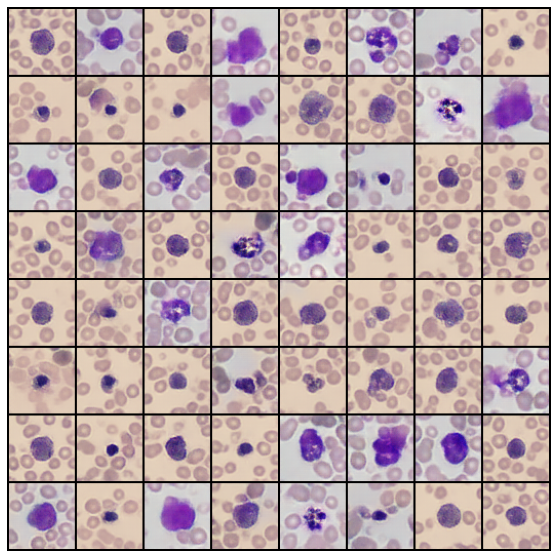

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Assuming 'generator' is your trained generator model and 'device' is defined
# Example usage: Generate and display images
generator.eval()  # Set to evaluation mode
with torch.no_grad():
    noise = torch.randn(64, 100, 1, 1, device=device)  # Generate 64 random noise vectors
    generated_images = generator(noise)

    # Convert images to a NumPy array for display
    generated_images_np = generated_images.cpu().numpy()  # Move to CPU and convert

    # Normalize pixel values to the range [0, 1] (assuming tanh activation in generator)
    generated_images_np = (generated_images_np + 1) / 2

    # Display the generated images
    grid_img = make_grid(generated_images, nrow=8, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid_img.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()


In [20]:
torch.save(generator, 'generator_model.pth')
torch.save(discriminator, 'discriminator_model.pth')
